## U-Net example for image segmentation

In this notebook, we will implement a U-Net architecture to perform image segmentation on dental images (inspired from [this article](http://www-o.ntust.edu.tw/~cweiwang/ISBI2015/challenge2/isbi2015_Ronneberger.pdf)). The dental images can be found [there](https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hxt48yk462-1.zip). There is a part if you want to train your network, but you can also use the model already trained.

Although the paper trains its model on images with a few number of teeth, I decided to train our example on images with the whole mouth displayed, as it will probably be more impressive and usefull.

### Download the github repository

In [1]:
!git clone https://github.com/ImagingYeditepe/Segmentation-of-Teeth-in-Panoramic-X-ray-Image.git

Cloning into 'Segmentation-of-Teeth-in-Panoramic-X-ray-Image'...


In [2]:
# change working directory
import os
os.chdir("Segmentation-of-Teeth-in-Panoramic-X-ray-Image")

### Downloading the images

It contains 116 x-ray images, and we also have the binary segmentation of each of them.

In [3]:
from download_dataset import *
path = "./Data"
if os.path.exists(path+'/DentalPanoramicXrays.zip') == False:
    os.mkdir(path)
    # download the images
    download_dataset(path+'/')

Downloading...
Completed...


### Load the input images

The size is predifined, and it is better for a U-Net to have a size that is a power of 2.

In [4]:
from images_prepare import *
X, X_sizes = pre_images((512,512),path,True)

### Load the target (segmented) images

In [5]:
from masks_prepare import *
Y = pre_splitted_masks(path='./Custom_Masks') #Custom Splitted MASKS size 512x512

### Normalize the data

Neural networks tend to work better with normalized data. Furthermore, the output of the network has values between 0 and 1 (sigmoid activation function) so it is a requirement for the segmemented images.

In [6]:
# From 0-255 to 0-1
X=np.float32(X/255)
Y=np.float32(Y/255)

# Spliting the train and test directory
x_train=X[:105,:,:,:]
y_train=Y[:105,:,:,:]
x_test=X[105:,:,:,:]
y_test=Y[105:,:,:,:]

### Show a random image and its target

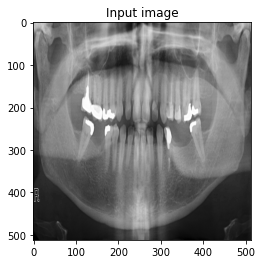

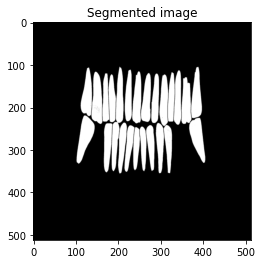

In [7]:
import random
import matplotlib.pyplot as plt
random_number=random.randint(0,104)

plt.imshow(x_train[random_number,:,:,0],cmap='gray')
plt.title("Input image")
plt.show()

plt.imshow(y_train[random_number,:,:,0],cmap='gray')
plt.title("Segmented image")
plt.show()

### Create the U-Net model

The U-net model is composed of several convolutional layers, batch normalisation and max pooling for the first part and then the max pooling are replaced by up convolution. This gives a sort of U shape to the output, hence the name.

As we want to perform binary segmentation, the last activation function is a sigmoid, that shows the probability of the pixel to be part of the tooth.

In [8]:
from model import *
model = UNET(input_shape=(512,512,1),last_activation='sigmoid')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

#### This is the step you might want to skip.
*There is already a model trained and usable, that will be loaded in the test section.*

### Training

The loss used for this model is the binary cross entropy. Indeed, it looks like a classification process where we need to classify the pixel as tooth or not tooth. As an extension, we could be using the cross entropy loss if we had more than 2 classes. The metric we use is accuracy, counting the number of correctly predicted pixels.

The batch size of 8 seems appropriate as the whole training data contains 106 images. The number of epoch around 150 is a little bit too much. However, it has been shown that U-net tend to not overfit easily so they are not a lot of issues with that.

In [ ]:
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Your choice batch and epoch 
model.fit(x_train,y_train,batch_size=8,epochs=150,verbose=1)
# The model will be saved after training
model.save("../model_perso.h5")

### Loading the saved model

In [9]:
import tensorflow as tf
# Load the pre-trained model (or the model you just trained and saved)
model = tf.keras.models.load_model("../model.h5")
# model = tf.keras.models.load_model("../model_perso.h5")

### Prediction on the test set

In [10]:
predict_img = model.predict(x_test)

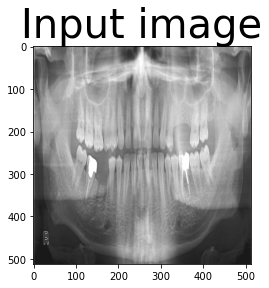

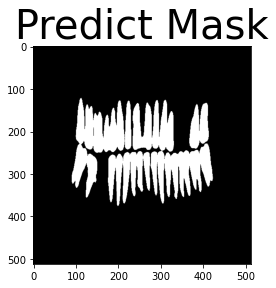

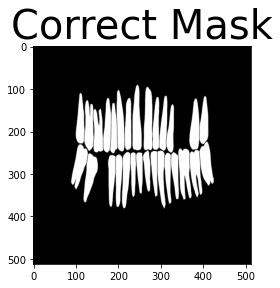

In [11]:
image_id = 1 # which image we want to look at between 0 and 10
assert image_id > -1 and image_id < 11, "The image you want to test must have an indice between 0 and 10"
predict = predict_img[image_id,:,:,0]
# used to find the bounding boxes
plt.imsave("./predict.png",predict)

plt.title("Input image",fontsize = 40)
plt.imshow(x_test[image_id,:,:,0],cmap='gray') # to have a binary image (we could be using an another threshold than the middle actually)
plt.show()

plt.title("Predict Mask",fontsize = 40)
plt.imshow(predict>0.5,cmap='gray') # to have a binary image (we could be using an another threshold than the middle actually)
plt.show()

plt.title("Correct Mask",fontsize = 40)
plt.imshow(y_test[image_id,:,:,0],cmap='gray') # to have a binary image (we could be using an another threshold than the middle actually)
plt.show()

### Some score and numbers to measure the results

We will calculate the dice score, precision along with the recall of the tested image. I trained the model on my own computer for 1 hour and obtain a dice score around 0.9. The best paper manage to obtain a dice score around 0.93. We can therefore hope that with a longer training time and more resources, we could reach such score.

In [12]:
def score(ground_truth : np.array, prediction : np.array) -> None :
    """
    Returns the dice score, precision and recall of the prediction over the ground truth
    The input need to be binary images
    """
    # for the dice score
    count_x, count_y, count_xy = 0, 0, 0
    # for precision and recall
    tp, fp, fn = 0, 0, 0
    h, w = ground_truth.shape
    for x in range(h) :
        for y in range(w) :
            # apply the formulas
            if prediction[x,y] :
                count_x += 1
                if not ground_truth[x,y] :
                    fp += 1
            if ground_truth[x,y] :
                count_y += 1
                if prediction[x,y] :
                    count_xy +=1
                    tp += 1
                else : 
                    fn += 1
                    
    dice_score = 2 * count_xy / (count_x + count_y)  * 100
    precision = tp / (tp + fp) * 100
    recall = tp / (tp + fn) * 100
    
    print("Dice score : {:.2f} \nPrecision : {:.2f} \nRecall : {:.2f}".format(dice_score,precision,recall))
    
score(y_test[image_id,:,:,0]>0.5,predict>0.5)

Dice score : 90.41 
Precision : 94.64 
Recall : 86.55


### Finding the contours

Using the cv2 library, it is possible to find the contours given the segmented image.

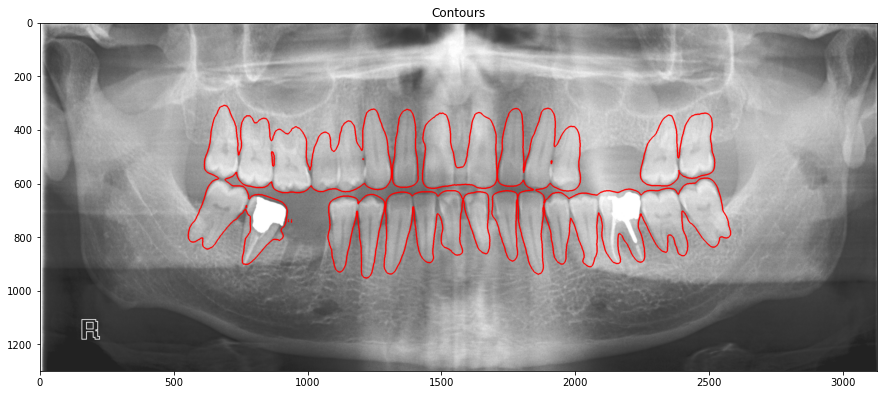

In [13]:
import cv2

img = cv2.imread("./Data/Images/{}.png".format(str(106+image_id)))

# resize to the same size as the input
predict1 = cv2.resize(predict, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# necessary for the cv2 function used afterwards
mask = np.uint8(predict1*255)
# 1 is higher than the threshold, 0 else
_, mask = cv2.threshold(mask, thresh=255/2, maxval=255, type=cv2.THRESH_BINARY)
# returns the contours of the mask
cnts, hierarch = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# draw said contours on the input image
img = cv2.drawContours(img[:,:,:], cnts, -1, (255, 0, 0) , 3)

# visualize the results
plt.figure(figsize = (15,10))
plt.imshow(img)
plt.title("Contours")
plt.show()

### Finding the box around the teeth

To perform this operation, the *CCA_Analysis* functions is here. 

This function finds the principal components (luckily the different teeth) after a step of opening and erosion (to separe each tooth). After that, we can compute a mask for each of the principal component. The area of said component needs to be higher than a threshold (here 2000 pixels) not to be discarded. 

Finally, the contour of the area is found and a cv2 function is used to compute the box that regroups these points. This box is the bounding box of the tooth.

There are 23 teeth.


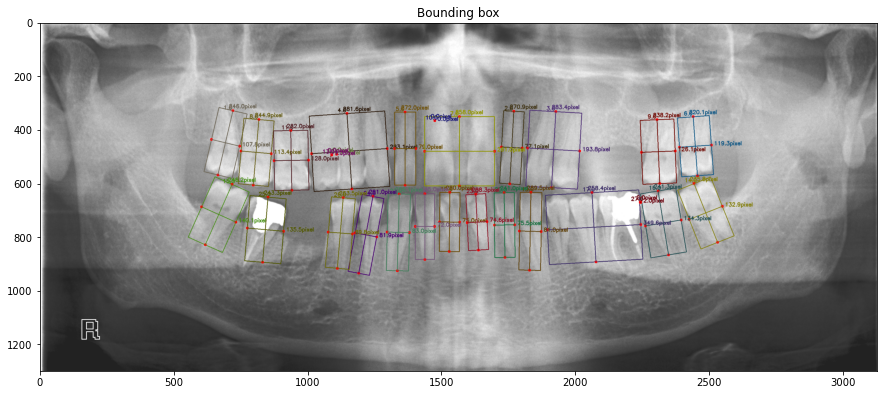

In [14]:
import cv2
from CCA_Analysis import *

# Read the images corresponding to the input and the prediction
img = cv2.imread("./Data/Images/{}.png".format(str(106+image_id)))
predicted = cv2.imread("./predict.png")

# resize to the same size as the input
predicted = cv2.resize(predicted, (img.shape[1],img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# performs the above-explained step
cca_result,teeth_count = CCA_Analysis(img,predicted,3,2)

# visualize the results
print("There are {} teeth.".format(teeth_count))
plt.figure(figsize = (15,10))
plt.imshow(cca_result)
plt.title("Bounding box")
plt.show()